In [1]:
# import numpy as np
import math
import matplotlib.pyplot as plt

import torch

import pennylane as qml
from pennylane import numpy as np

from PIL import Image

import time
import warnings
warnings.filterwarnings("ignore")

## Extracting Hearts Template

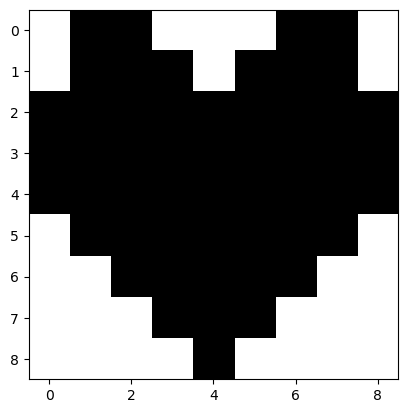

In [2]:
template_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/hearts_work/heart_template.png").convert("L")
template_img = torch.tensor(np.array(template_img))/255.0
plt.imshow(template_img, cmap='gray')

In [3]:
template_img = template_img.flatten()

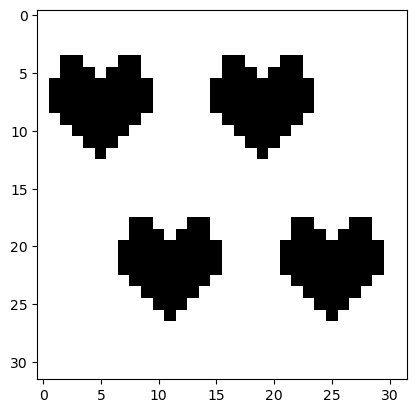

In [4]:
full_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/hearts_work/heartss.png").convert("L")
full_img = torch.tensor(np.array(full_img))/255.0
plt.imshow(full_img, cmap='gray')

In [5]:
unfold = torch.nn.Unfold(kernel_size=(9,9),stride=3)
img_patches = unfold(full_img.unsqueeze(0).unsqueeze(0))
img_patches = img_patches.squeeze(0).T
print("Number of image patches:", img_patches.shape[0])
print("Single Image Patch Shape:", img_patches.shape[1])

Number of image patches: 64
Single Image Patch Shape: 81


In [6]:
# ex_patch = img_patches[-1].reshape(9,9)
# plt.imshow(ex_patch, cmap='gray')

In [7]:
### Verifying atleast one patch is similar to the template

def find_similar_patches(img_patches, template_img):
    
    similarity = torch.nn.functional.cosine_similarity(img_patches, template_img.unsqueeze(0), dim=1)
    
    similar_patches = []
    for i in range(len(similarity)):
        if similarity[i] > 0.99:  # Adjust threshold as needed
            similar_patches.append(i)

    if len(similar_patches) == 0:
        print("No patches are identical to the template.")
    else:
        print(f"Found {len(similar_patches)} patches that are identical to the template at indices: {similar_patches}")
    
    return similar_patches


similar_patches = find_similar_patches(img_patches, template_img)


Found 1 patches that are identical to the template at indices: [55]


## Getting Wavefunction of Dataset

In [8]:
n_qubits = math.ceil(math.log2(img_patches.shape[1]))
n_ancillas = math.ceil(math.log2(img_patches.shape[0]))
total_qubits = n_qubits + n_ancillas
print("Number of qubits:", n_qubits)
print("Number of ancillas:", n_ancillas)

Number of qubits: 7
Number of ancillas: 6


In [9]:
def prepare_padded_data(dataset):

    n = math.ceil(math.log2(dataset.shape[1]))
    padded_data = torch.zeros((dataset.shape[0], 2**n))
    padded_data[:, :dataset.shape[1]] = dataset

    for d in padded_data:
        eps = 1e-6
        
        if torch.linalg.norm(d) < 1e-8:
            d = torch.full_like(d, eps)
        d /= torch.linalg.norm(d)

    return padded_data

In [10]:
padded_temp_img= prepare_padded_data(template_img.unsqueeze(0)).squeeze(0)
print("Padded Template Image Shape:", padded_temp_img.shape)

Padded Template Image Shape: torch.Size([128])


In [11]:
target_dm = torch.einsum("i,j -> ij", padded_temp_img, padded_temp_img)
target_dm.shape

torch.Size([128, 128])

In [12]:
padded_img_patches = prepare_padded_data(img_patches)
print("Padded Image Patches Shape:", padded_img_patches.shape)

Padded Image Patches Shape: torch.Size([64, 128])


In [13]:
def encode_conditional_state_with_ancilla_last(data,total_qubits):

    psi_full = torch.zeros(2**total_qubits, dtype=torch.complex64)

    for i in range(2**n_qubits):
        base_index = i * 64  # because 2^6 = 64 ancilla states

        for j in range(data.shape[0]):
            psi_full[base_index + j] = data[j][i]   

        # psi_full[base_index + 0] = data[0][i]  # |000⟩ ancilla
        # psi_full[base_index + 1] = data[1][i]  # |001⟩ ancilla
        # psi_full[base_index + 2] = data[2][i]
        # psi_full[base_index + 3] = data[3][i]
        # psi_full[base_index + 4] = data[4][i]
        # psi_full[base_index + 5] = data[5][i]
        # psi_full[base_index + 6] = data[6][i]
        # psi_full[base_index + 7] = data[7][i]
        # psi_full[base_index + 8] = data[8][i]
        # psi_full[base_index + 9] = data[9][i]
        # psi_full[base_index + 10] = data[10][i]
        # psi_full[base_index + 11] = data[11][i]
        # psi_full[base_index + 12] = data[12][i]
        # psi_full[base_index + 13] = data[13][i]

    return psi_full / torch.linalg.norm(psi_full)

data_full = encode_conditional_state_with_ancilla_last(padded_img_patches, total_qubits)
data_full.shape

torch.Size([8192])

In [14]:
target_full_dm = torch.einsum("i,j -> ij", data_full, data_full)
target_full_dm.shape

torch.Size([8192, 8192])

## Functions

In [15]:
from pennylane.math import reduce_statevector

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real



def qcbm(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    full_psi = circuit_fn(params)
    px = reduce_statevector(full_psi, indices=range(num_qubits))
    loss = trdistance_loss(px, py)
    return loss


In [16]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)
        qml.RY(ising_params1[i],wires=i)
        qml.RZ(ising_params2[i],wires=i)

    for i in range(total_qubits-1):
        qml.CNOT(wires=[i,i+1])
    qml.CNOT(wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds1 = 6

@qml.qnode(dev,interface="torch",diff_method="backprop")
def circuit(input_params,folds=folds1,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):

    for i in range(folds):
        qcbm_circuit(params=input_params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


## Training the Model

In [17]:
initial_params = torch.rand((folds1, 3 * total_qubits), requires_grad=True, dtype=torch.float32)

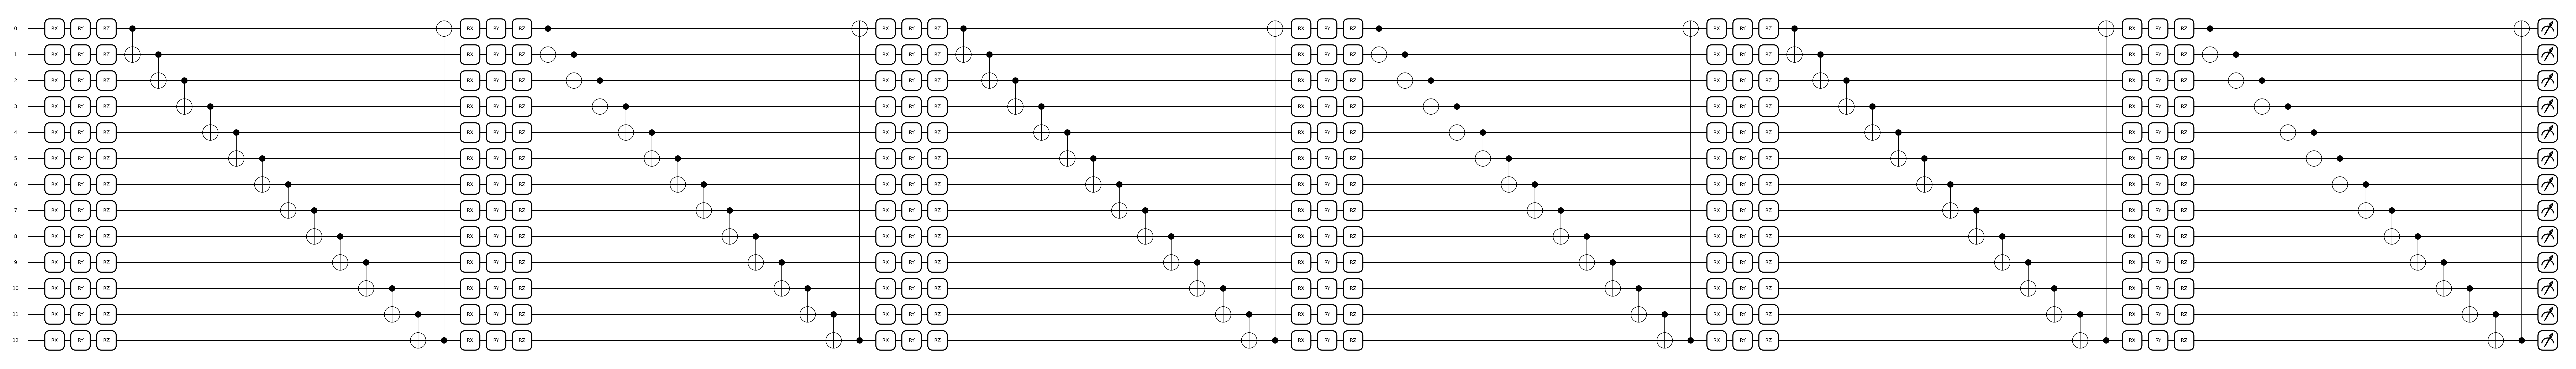

In [18]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [19]:
weights = initial_params
lr = 0.01
opt = torch.optim.Adam([weights], lr=lr)


loss_history = []
min_loss = qcbm(circuit, weights, target_dm)
optimal_params = torch.zeros((folds1, 3* total_qubits), dtype=torch.float32)
n_epochs = 1000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    loss = qcbm(circuit, weights, target_dm)
    loss.backward()
    opt.step()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss} Time taken per iter: {end_time-start_time}")
    loss_history.append(loss.item())

    if loss < min_loss:
        min_loss = loss
        optimal_params = weights.detach().clone()


Step: 10 Loss: 0.49185679117597436 Time taken per iter: 0.08529376983642578
Step: 20 Loss: 0.4701804362486861 Time taken per iter: 0.07822012901306152
Step: 30 Loss: 0.4424326007963841 Time taken per iter: 0.0822904109954834
Step: 40 Loss: 0.41481135292467286 Time taken per iter: 0.09342598915100098
Step: 50 Loss: 0.3806863643014199 Time taken per iter: 0.08692097663879395
Step: 60 Loss: 0.34131168712452015 Time taken per iter: 0.08966302871704102
Step: 70 Loss: 0.3083416024183021 Time taken per iter: 0.0867917537689209
Step: 80 Loss: 0.27746798581701154 Time taken per iter: 0.08726310729980469
Step: 90 Loss: 0.25261715912213356 Time taken per iter: 0.08509993553161621
Step: 100 Loss: 0.22799558470720152 Time taken per iter: 0.08912205696105957
Step: 110 Loss: 0.20675795024025515 Time taken per iter: 0.08930015563964844
Step: 120 Loss: 0.18672102642049657 Time taken per iter: 0.08710312843322754
Step: 130 Loss: 0.16842875088222928 Time taken per iter: 0.08629775047302246
Step: 140 Loss

Text(0.5, 1.0, 'Loss Over Epochs')

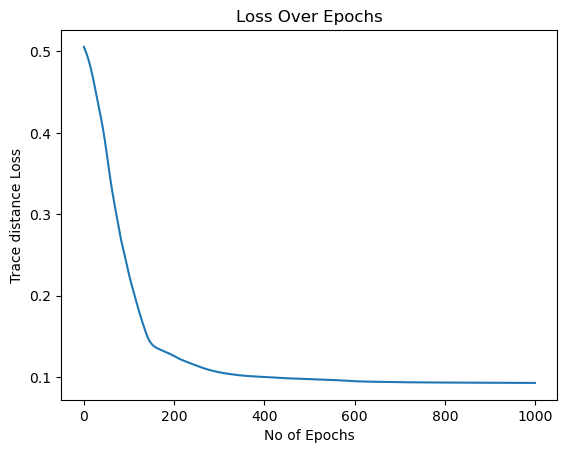

In [20]:
plt.plot(loss_history)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")
plt.title("Loss Over Epochs")

In [21]:
min_loss = loss_history[np.argmin(loss_history)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.09293453311543942


In [22]:
psi = circuit(optimal_params)
reduced_dm = reduce_statevector(psi,indices=range(n_qubits))

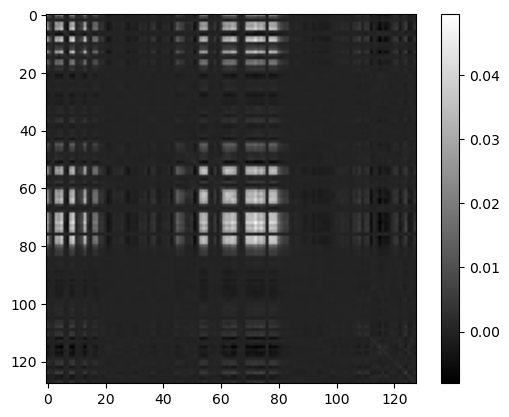

In [23]:
plt.imshow(reduced_dm.real,cmap="grey")
plt.colorbar()

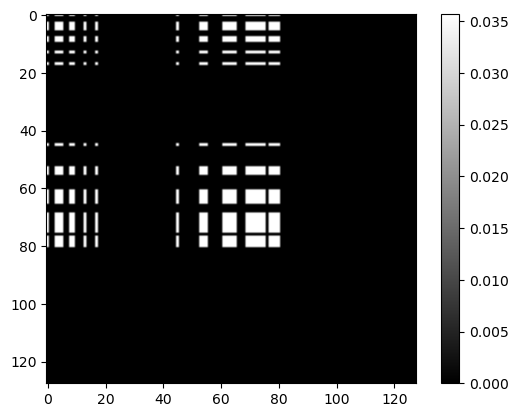

In [24]:
plt.imshow(target_dm.real,cmap="grey")
plt.colorbar()

In [25]:
### NO Training Check
no_training_check_fidelity = torch.abs((psi.conj().T @ data_full)**2)
no_training_check_fidelity

tensor(0.0074)

## Register Basis Training

In [26]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """
    
    # px_dm = qml.math.dm_from_state_vector(px)
    fidelity = torch.abs((px.conj().T @ py)**2)

    return fidelity

def vqc(circuit_fn,  params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):
    """
    Variational Quantum Circuit (VQC) function to compute the loss.
    """
    full_psi = circuit_fn(params)
    fid_loss = fidelity_loss(full_psi, py)
    # loss = full_psi[0].real
    return -1 * fid_loss

# def vqc(circuit_fn, params:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

#     full_psi = circuit_fn(params).real
#     loss = full_psi[0]
#     return -1 * loss

In [27]:
def vqc_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=n_qubits+i)
        qml.RY(ising_params1[i],wires=n_qubits+i)
        qml.RZ(ising_params2[i],wires=n_qubits+i)

    for i in range(total_qubits-1):
        qml.CNOT(wires=[n_qubits+i,n_qubits+i+1])
    qml.CNOT(wires=[n_qubits+total_qubits-1,n_qubits])



dev2 = qml.device("default.qubit",wires=total_qubits)
folds2 = 3

@qml.qnode(dev2,interface="torch",diff_method="backprop")
def reg_circuit(input_params,trained_params=optimal_params,folds=[folds1,folds2],num_qubits=n_ancillas,total_qubits=total_qubits):
# def reg_circuit(input_params,folds=[folds1,folds2],num_qubits=n_ancillas,total_qubits=total_qubits):
    
    # qml.AmplitudeEmbedding(padded_temp_img, wires=range(n_qubits))
    for i in range(folds[0]):
        qcbm_circuit(params=trained_params[i],total_qubits=total_qubits)
    for i in range(n_qubits, total_qubits):
        qml.Hadamard(wires=i)
    for i in range(folds[1]):
        vqc_circuit(params=input_params[i],total_qubits=n_ancillas)

    # qml.QubitDensityMatrix(target_full_dm.conj().T, wires=range(total_qubits))
    # qml.StatePrep(data_full, wires=range(total_qubits)).adjoint
    
    output = qml.state()

    return output


In [28]:
reg_params = torch.rand((folds2, 3 * n_ancillas), requires_grad=True, dtype=torch.float32)

(<Figure size 12700x1400 with 1 Axes>, <Axes: >)

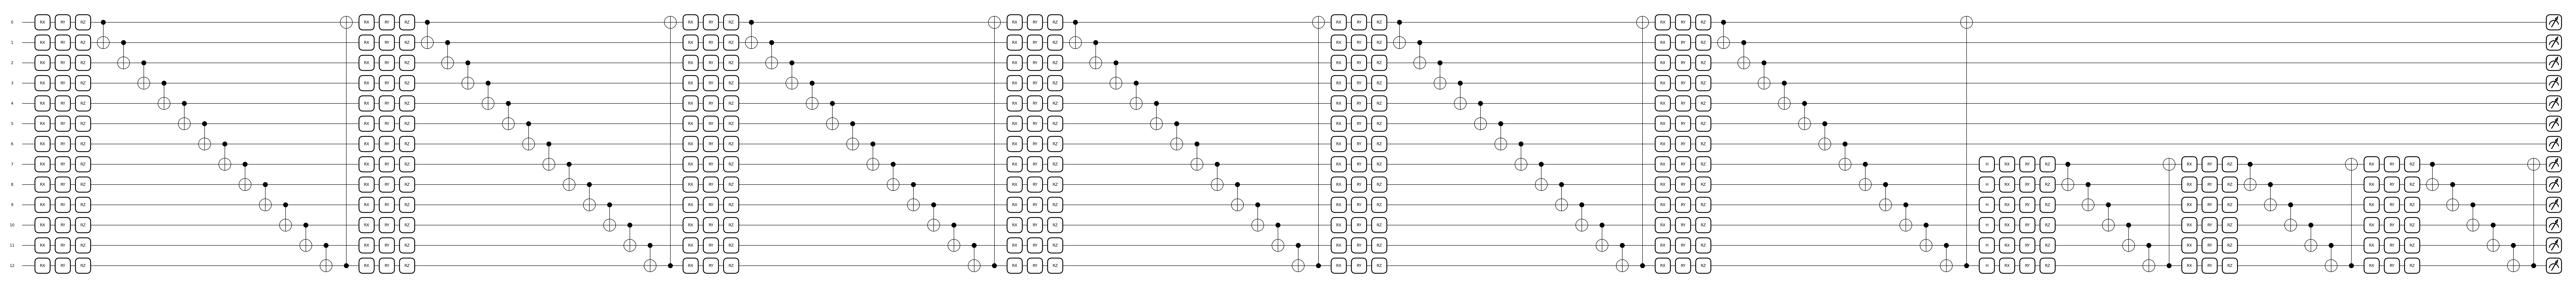

In [29]:
qml.draw_mpl(reg_circuit)(reg_params)

In [30]:
no_training_check = reg_circuit(reg_params)
no_training_check_loss = vqc(reg_circuit,reg_params,data_full)
print("No Training Loss:",no_training_check_loss.item())

No Training Loss: -0.005630048923194408


In [31]:
weights = reg_params
opt = torch.optim.Adam([weights], lr=0.01)

reg_loss_history = []
optimal_reg_params = torch.zeros((folds2, 3 * n_ancillas), dtype=torch.float32)
min_loss = float('inf')
n_epochs = 1000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    opt.zero_grad()
    # loss_val = vqc(reg_circuit, weights, target_full_dm)
    loss_val = vqc(reg_circuit,weights,data_full)
    loss_val.backward()
    opt.step()
    end_time = time.time()

    if i%2 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")
    reg_loss_history.append(-1 * loss_val.item())

    if loss_val < min_loss:
        min_loss = loss_val
        optimal_reg_params = weights.detach().clone()


Step: 2 Loss: -0.006704090163111687 Time taken per iter: 0.0547640323638916
Step: 4 Loss: -0.009114949032664299 Time taken per iter: 0.054006099700927734
Step: 6 Loss: -0.011867695488035679 Time taken per iter: 0.05552792549133301
Step: 8 Loss: -0.014965328387916088 Time taken per iter: 0.054593801498413086
Step: 10 Loss: -0.01844533160328865 Time taken per iter: 0.06467986106872559
Step: 12 Loss: -0.02237001806497574 Time taken per iter: 0.06538701057434082
Step: 14 Loss: -0.026767859235405922 Time taken per iter: 0.06485986709594727
Step: 16 Loss: -0.031641632318496704 Time taken per iter: 0.06277084350585938
Step: 18 Loss: -0.037002187222242355 Time taken per iter: 0.06376910209655762
Step: 20 Loss: -0.042871005833148956 Time taken per iter: 0.06375312805175781
Step: 22 Loss: -0.049252960830926895 Time taken per iter: 0.06027483940124512
Step: 24 Loss: -0.056109629571437836 Time taken per iter: 0.05882906913757324
Step: 26 Loss: -0.06334640830755234 Time taken per iter: 0.0543007850

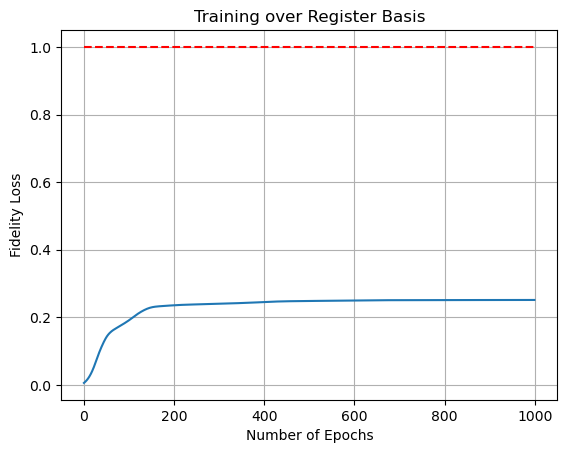

In [32]:
plt.plot(reg_loss_history)
plt.hlines(y=[1.0],xmin=0,xmax=len(reg_loss_history),colors='r',linestyles='dashed',label='Ideal Fidelity')
plt.xlabel("Number of Epochs")
plt.ylabel("Fidelity Loss")
plt.title("Training over Register Basis")
plt.grid(True)
plt.show()

## Obtaining the position of the hearts

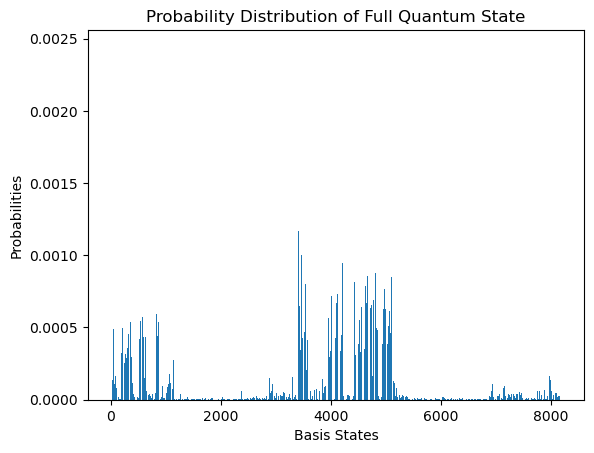

In [33]:
full_psi = reg_circuit(optimal_reg_params)

plt.bar(range(2**total_qubits), torch.abs(full_psi)**2)
plt.xlabel("Basis States")
plt.ylabel("Probabilities")
plt.title("Probability Distribution of Full Quantum State")
plt.show()

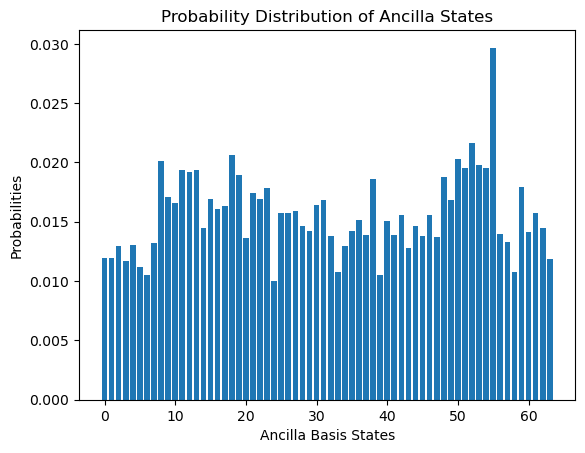

In [34]:
reg_state_obtained = reduce_statevector(full_psi, indices=range(n_qubits,total_qubits))

plt.bar(range(2**n_ancillas), torch.diag(reg_state_obtained))
plt.xlabel("Ancilla Basis States")
plt.ylabel("Probabilities")
plt.title("Probability Distribution of Ancilla States")
plt.show()

In [35]:
max_prob_index = torch.argmax(torch.diag(reg_state_obtained.real)).item()
print(f"Max Probability Index: {max_prob_index}")

Max Probability Index: 55


## Obtaining the Heart at Max Probability Register Basis Index

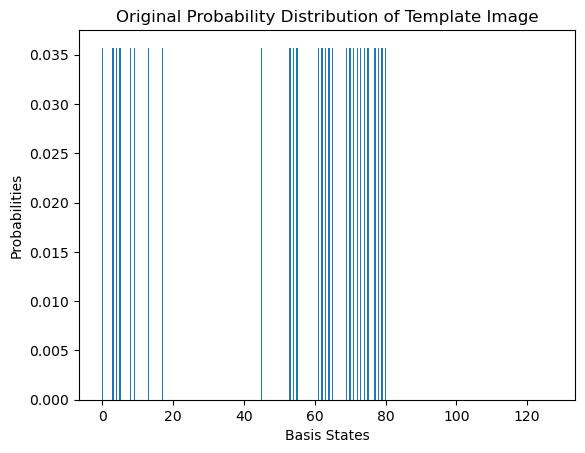

In [36]:
x = np.arange(2**7)
plt.bar(x,np.abs(padded_temp_img)**2, 0.4)
plt.xlabel("Basis States")
plt.ylabel("Probabilities")
plt.title("Original Probability Distribution of Template Image")
plt.show()

In [37]:
identity_dm = torch.eye(2**n_qubits, dtype=torch.complex64)

bitstring = format(max_prob_index, f"0{n_ancillas}b")        # '110111'
bits = [(max_prob_index >> j) & 1 for j in range(n_ancillas)]  # [1, 1, 1, 0, 1, 1]
ket = torch.zeros(2**n_ancillas, dtype=torch.complex64)
ket[max_prob_index] = 1.0
proj_55 = torch.outer(ket, ket.conj())

In [38]:
output = torch.einsum("i,j -> ij", full_psi, full_psi)

projector = torch.kron(identity_dm, proj_55)
projected_dm = projector @ output @ projector.conj().T

projected_dm /= torch.trace(projected_dm).real
reduced_heart_dm = qml.math.partial_trace(projected_dm, indices=range(n_qubits, total_qubits))

In [39]:
torch.sum(torch.diag(reduced_heart_dm.real))

tensor(1.0000, dtype=torch.float64)

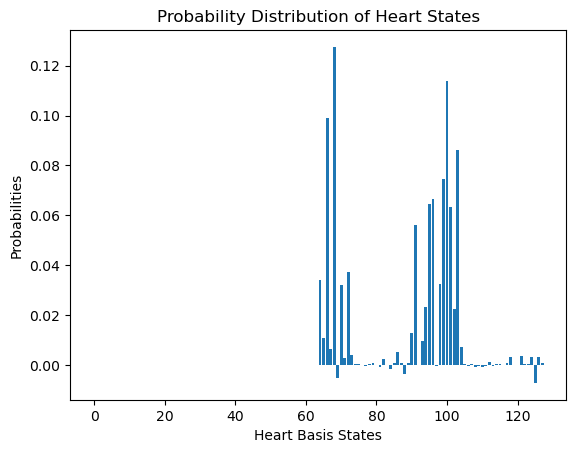

In [40]:
plt.bar(range(2**n_qubits), torch.diag(reduced_heart_dm.real))
plt.xlabel("Heart Basis States")
plt.ylabel("Probabilities")
plt.title("Probability Distribution of Heart States")
plt.show()

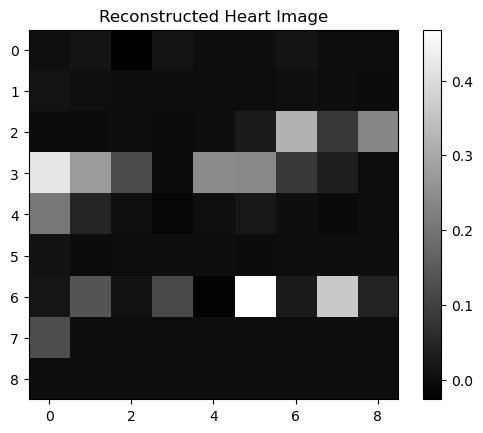

In [46]:
image = torch.diag(reduced_heart_dm.real)
#invert the image array such that the last element is the first pixel
image = image.flip(0)[:9*9]
image /= torch.norm(image)

plt.imshow(image.reshape(9,9), cmap='gray')
plt.colorbar()
plt.title("Reconstructed Heart Image")
plt.show()